# Purpose
- Purpose of this notebook is to;
    - Perform EDA to see if some time series has trend ,seasonal and/or cyclical patterns
    - This will inform how we feature engineer

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# change current working directory to the root of the project
import os
os.chdir(os.path.dirname(os.getcwd()))

# imports
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf

from src import plot

# Import Pre-processed Data

In [2]:
# import csv data into pandas dataframe
df_data = pd.read_csv('data/preprocessed/data_preprocessed.csv')
df_holidays = pd.read_csv('data/preprocessed/holidays_preprocessed.csv')
df_stores = pd.read_csv('data/preprocessed/stores_preprocessed.csv')
df_oil = pd.read_csv('data/preprocessed/oil_preprocessed.csv')
df_transactions = pd.read_csv('data/preprocessed/transactions_preprocessed.csv')

In [3]:
# combine store and family columns to create unique IDs
df_data_preprocessed = df_data.copy()
df_data_preprocessed['store_family'] = df_data['store_nbr'].astype(str) + '_' + df_data['family'].astype(str)
df_data_preprocessed.drop(['family', 'store_nbr'], axis=1, inplace=True)
df_data_preprocessed

,date,sales,onpromotion,store_family
0,2013-01-01,0.0,0,1_AUTOMOTIVE
1,2013-01-02,2.0,0,1_AUTOMOTIVE
2,2013-01-03,3.0,0,1_AUTOMOTIVE
3,2013-01-04,3.0,0,1_AUTOMOTIVE
4,2013-01-05,5.0,0,1_AUTOMOTIVE
...,...,...,...,...
3008011,2017-08-11,0.0,0,54_SEAFOOD
3008012,2017-08-12,1.0,1,54_SEAFOOD
3008013,2017-08-13,2.0,0,54_SEAFOOD
3008014,2017-08-14,0.0,0,54_SEAFOOD


# EDA

In [4]:
# unique IDs values
display(len(df_data_preprocessed['store_family'].unique()))

1782

In [5]:
display(df_data['family'].unique())
display(df_data['store_nbr'].unique())

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

# Plots for Average Sales of all Stores and Families

In [6]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

sns.set_style('whitegrid')

/var/folders/rx/jl4f7yr95xd03cgb4sg2w99h0000gn/T/ipykernel_2921/1002799576.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [7]:
df_data['date'] = pd.to_datetime(df_data.date)
df_data['date'] = df_data.date.dt.to_period('D')
store_sales = df_data.set_index(['store_nbr', 'family', 'date']).sort_index()

,sales,week,day
date,,,
2017-01-01,6.780304,52,6
2017-01-02,786.928379,1,0
2017-01-03,619.740224,1,1
2017-01-04,555.608004,1,2
2017-01-05,436.375395,1,3
...,...,...,...
2017-08-11,463.733851,32,4
2017-08-12,444.798280,32,5
2017-08-13,485.768618,32,6


- **Trend**

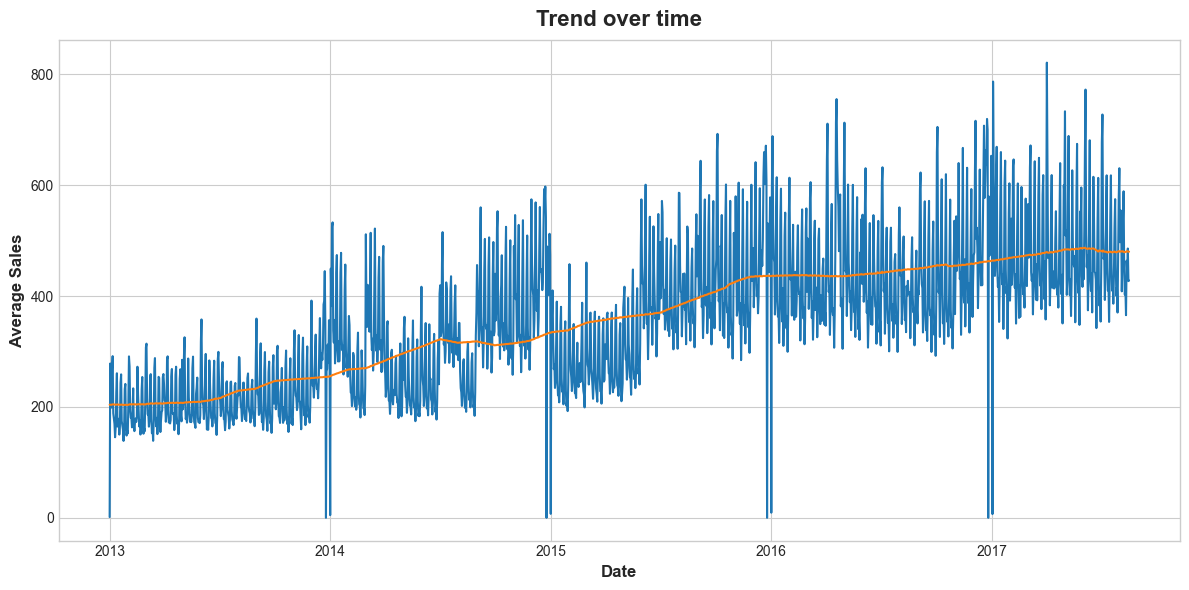

In [8]:
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
)

average_sales.index = average_sales.index.to_timestamp()
moving_average = average_sales['sales'].rolling(window=365, center=True, min_periods=183).mean()

# using seaborn, plot the moving average
plt.figure(figsize=(12, 6))
sns.lineplot(data=average_sales, x='date', y='sales', label='Sales')
sns.lineplot(data=average_sales, x='date', y=moving_average, label='Moving Average')
plt.title('Trend over time')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.legend([],[], frameon=False)
plt.show()

- **Seasonality**

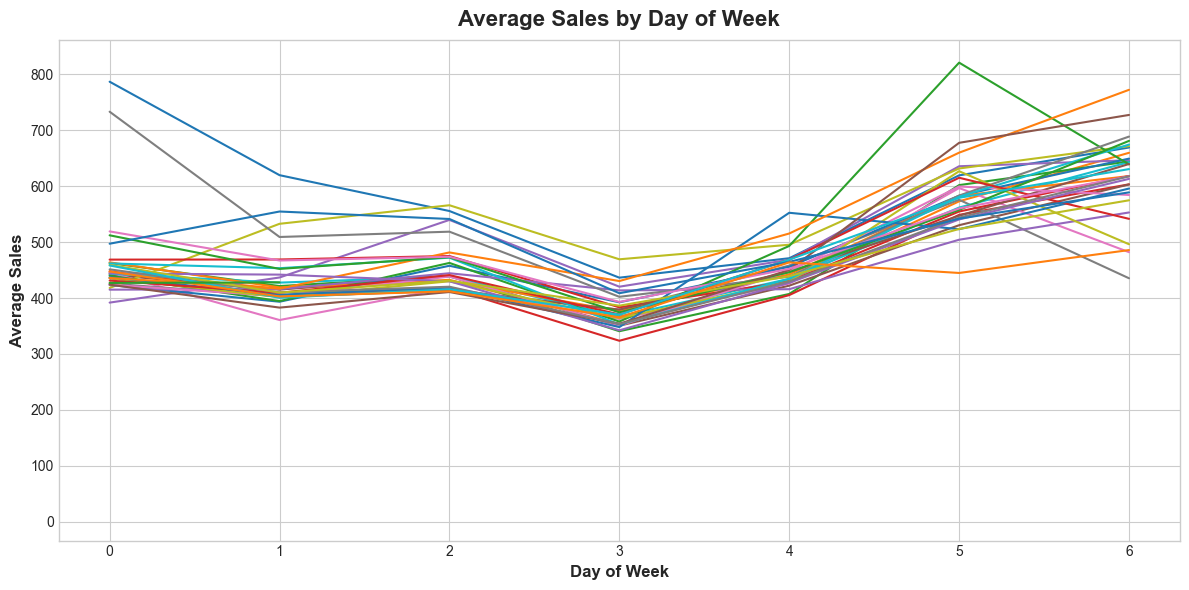

In [10]:
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

average_sales['week'] = average_sales.index.week
average_sales['day'] = average_sales.index.dayofweek
average_sales.drop(columns=['onpromotion'], inplace=True)
average_sales

plt.figure(figsize=(12, 6))
sns.lineplot(data=average_sales, x='day', y='sales', hue='week', palette='tab10')
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.legend([],[], frameon=False)
plt.show()

/var/folders/rx/jl4f7yr95xd03cgb4sg2w99h0000gn/T/ipykernel_2921/4229336980.py:3: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


Text(0.5, 1.0, 'Periodogram')

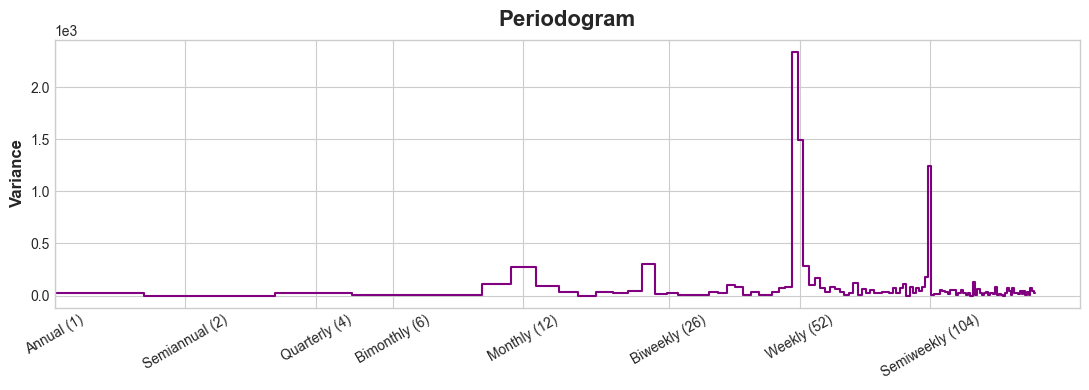

In [11]:
ax = None
from scipy.signal import periodogram
fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
freqencies, spectrum = periodogram(
    average_sales.sales,
    fs=fs,
    detrend='linear',
    window="boxcar",
    scaling='spectrum',
)
if ax is None:
    _, ax = plt.subplots()
ax.step(freqencies, spectrum, color="purple")
ax.set_xscale("log")
ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
ax.set_xticklabels(
    [
        "Annual (1)",
        "Semiannual (2)",
        "Quarterly (4)",
        "Bimonthly (6)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)",
        "Semiweekly (104)",
    ],
    rotation=30,
)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.set_ylabel("Variance")
ax.set_title("Periodogram")

- **Cyclicality**

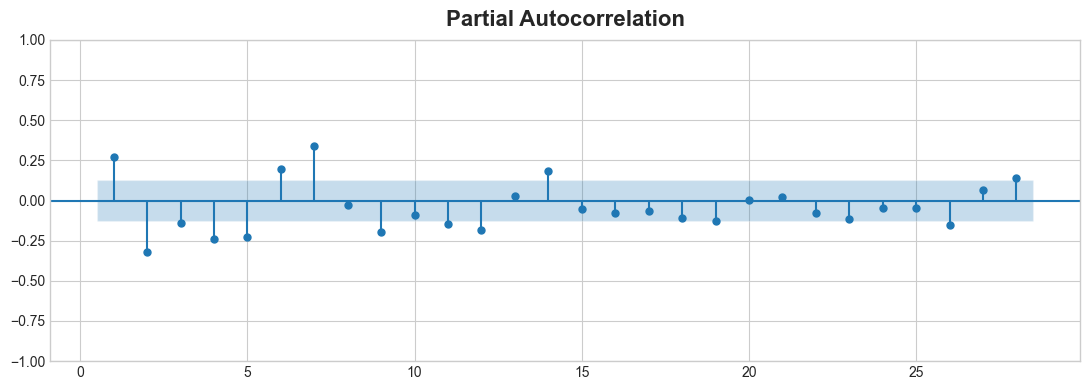

In [12]:
_ = plot_pacf(average_sales.sales, lags=28, method="ywm", zero=False)

# Summary
- There is a clear **trend** in the data, with sales increasing over time
- There is a clear **short term seasonality** in the data, based on the weekly pattern
- There is a clear **long term seasonality** in the data, based on the periodogram
- There is **cyclicality** in the data based on the correlogram
